In [1]:
import sys
import rosbag
import time
import rospy
import os
import argparse
import math
import re
import h5py
import numpy as np
import ros_numpy
import matplotlib.pyplot as plt
from sensor_msgs.msg import Image, PointCloud2, PointField
from cv_bridge import CvBridge, CvBridgeError
from tqdm import tqdm, trange

## user define
- frame rate
- chunck length
- bags directory
- output file path/name
- topics need to transfer
- reference
    - https://support.hdfgroup.org/HDF5/doc/Advanced/Chunking/
    - http://docs.h5py.org/en/stable/high/dataset.html

In [2]:
frame_rate = 5  # Hz
chunck_len = 512  # number of frames in .hdf5 file

date_time = '0727_1005'

bags_dir = '/media/ray/ARG_SSD/0727/'+date_time
output_dir = '/media/ray/intelSSD/mmdemo_'+date_time+'/'
try:
    os.mkdir(output_dir)
except:
    pass

output_file_prefix = output_dir + 'mmdemo_'+date_time

topic_list = {
    '/husky2/velodyne1/velodyne_points': 'lidar',
    '/husky2/mmwave_mapping':'mmwave',
    '/husky2/RL/scan_mmwave':'mmwave_scan',
    '/husky2/RL/scan':'laser_scan',
    '/husky2/husky_velocity_controller/cmd_vel':'action',
    '/husky2/husky_velocity_controller/odom':'odom'
}

#info for meta
meta_info = {
    'vehicle':'husky',
    'place':'EE',
    'date_time':date_time,
    'frame_rate':frame_rate,
}


## user define 
msg to numpy array

ros_numpy : https://github.com/eric-wieser/ros_numpy

- image (width,height,channel)
- point cloud (xyz, number_of_points)

In [3]:
def msg_to_np(topic,msg):
    data = None
    if topic == '/husky2/velodyne1/velodyne_points':
        data_tmp = ros_numpy.point_cloud2.pointcloud2_to_xyz_array(
            msg)
        # swapaxis (3,points_number)
        data_tmp = np.swapaxes(data_tmp, 1, 0)
        data = []
        for i in range(data_tmp.shape[0]):
            data.append(np.array(data_tmp[i]))

    elif topic == '/husky2/mmwave_mapping':
        data_tmp = ros_numpy.point_cloud2.pointcloud2_to_xyz_array(
            msg)
        # swapaxis (3,points_number)
        data_tmp = np.swapaxes(data_tmp, 1, 0)
        data = []
        for i in range(data_tmp.shape[0]):
            data.append(np.array(data_tmp[i]))
            
    elif topic=='/husky2/RL/scan_mmwave':
        data = np.clip(np.array(msg.ranges,dtype=np.dtype('float32')),0,5)
        
    elif topic=='/husky2/RL/scan':
        data = np.clip(np.array(msg.ranges,dtype=np.dtype('float32')),0,5)
    
    elif topic=='/husky2/husky_velocity_controller/cmd_vel':
        data = np.array([msg.linear.x,msg.angular.z])
        data = data / 0.4
        data = np.clip(data,[0,-1],[1,1]).astype(np.dtype('float32'))
        
    elif topic=='/husky2/husky_velocity_controller/odom':
        data = np.array([msg.pose.pose.position.x,msg.pose.pose.position.y],dtype=np.dtype('float32'))
        
    return data

## add dataset
    lidar has unknown length data
    need to use special_dtype

In [4]:
def add_dataset(f, key, data, chunck_len):
    if key == 'lidar' or key =='mmwave':
        dt = h5py.special_dtype(vlen=np.dtype('float32'))
        shape = (chunck_len, 3)
        max_shape = (None, 3)
    else:
        dt = data.dtype
        shape = (chunck_len,) + data.shape
        max_shape = (None,) + data.shape
    
    return f.create_dataset(key, shape=shape,
                        maxshape=max_shape, dtype=dt, chunks=True)

In [5]:
def add_meta(f, step):
    meta = f.create_group('metadata')
    
    for i,(key,value) in enumerate(meta_info.items()):
        meta.attrs[key] = value
    
    for i,(key,value) in enumerate(topic_list.items()):
        meta.attrs[value] = key
        
    meta.attrs["trajectory_length"] = step

## start process bags
rosbag : http://wiki.ros.org/rosbag/Code%20API

In [6]:
bags = os.listdir(bags_dir)[::-1]
bags.sort()
b = None
frame = 0
step = 0
epi = 0
tp = None
dropped_frame = 0
mark, report = {}, {}
for value in topic_list.values():
    mark.update({value:0})
    report.update({value:[]})

f = h5py.File(output_file_prefix+"_%03d.hdf5"%epi, 'w')
    
pbar = tqdm(bags)

for bag_name in pbar:
    b = rosbag.Bag(bags_dir+'/'+bag_name)
    for topic, msg, t in b.read_messages(topic_list.keys()):
        if tp is None:
            tp = t
        else:
            if not topic_list[topic] in f.keys():
                # create dataset
                data = msg_to_np(topic,msg)
                dset = add_dataset(f,topic_list[topic],data,chunck_len)

            f[topic_list[topic]][step] = msg_to_np(topic,msg)
            mark[topic_list[topic]] = 1
            
            # cut frame ------------------------------------------------------------------
            if (t-tp).to_sec() > 1./frame_rate:
                tp = t
                drop = False
                frame += 1
                # if there is one msg missing in this frame
                # drop this frame
                for i, (key, value) in enumerate(mark.items()):
                    report[key].append(value)
                    if value is 0:
                        drop = True
                        dropped_frame += 1
                    mark[key] = 0

                pbar.set_description("frame:%d, drop:%d , bag:%s"%(frame,dropped_frame,bag_name))
                if not drop:
                    step += 1
                    if step == chunck_len:
                        epi += 1
                        add_meta(f,step)
                        f.close()
                        step = 0
                        del f
                        f = h5py.File(output_file_prefix+"_%03d.hdf5"%epi, 'w')
                    # end if
               # end if
            # end if
        # end if
    # end for
    b.close()
    del b
add_meta(f,step)
f.close()
print '\nfinish'

frame:4842, drop:323 , bag:subt_2020-07-27-10-21-49_26.bag: 100%|██████████| 27/27 [02:50<00:00,  6.32s/it]


finish


## status report
    show the dropped frame numbers

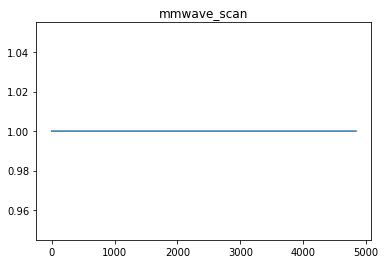

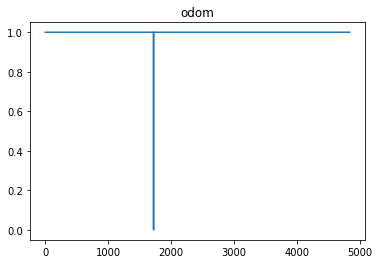

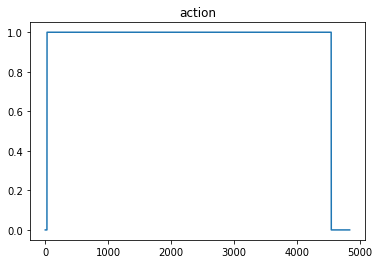

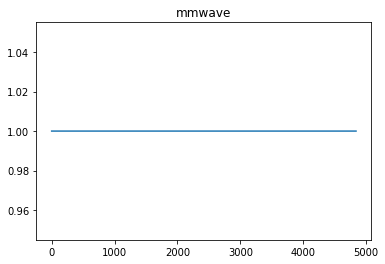

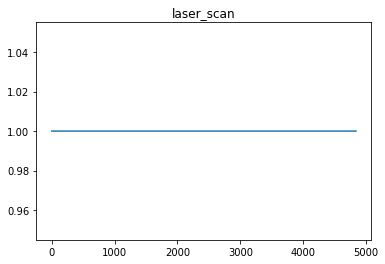

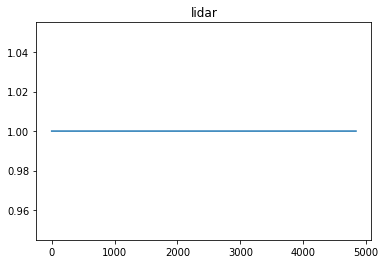

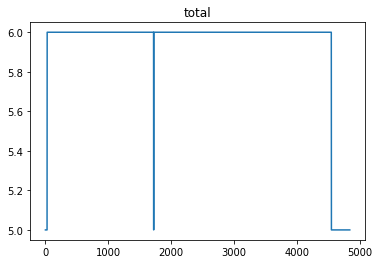

In [7]:
stat = []
for i, (key, value) in enumerate(report.items()):
    stat.append(value)
    plt.title(key)
    plt.plot(value)
    plt.show()
total = np.sum(stat,axis=0)
plt.title('total')
plt.plot(total)
plt.show()